In [10]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%reload_ext autoreload
%autoreload 2


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [3]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
_, _, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

Structure of lfp_data: <class 'numpy.ndarray'>, (1, 2)
Loading Flight Room | 32622 | 231007 from cache...
Positional data shape: (841160, 3)
Cleaned positional data shape: (841160, 3)


big raw data structure


In [4]:
BIGRAW = load_and_align_lfp_and_pos(data_path,bat_id,date,lfp_file_path,use_cache=True)

Loading cached aligned data from ./lfp_pos_cache/d4acd319977a5004e71a82fb97f02cb7_aligned_data.npy


In [9]:
BIGRAW[:,2]

array([ 576.,  384.,  384., ..., 1728., 1600., 1664.])

In [5]:
# Cache file path
cache_file = "masked_BIGRAW_cache.npy"

# Check if the cached file exists
if os.path.exists(cache_file):
    print(f"Loading masked_BIGRAW from cache: {cache_file}")
    masked_BIGRAW = np.load(cache_file)
else:
    print("Calculating masked_BIGRAW...")

    # Define channel ranges for each region
    probe1_ca1_range = slice(352 - 1, 340 - 1, -1)  # 0-based indices
    probe1_ca3_range = slice(214 - 1, 196 - 1, -1)  # 0-based indices
    probe2_ca1_range = slice(376 - 1 + 192, 356 - 1 + 192, -1)  # Probe 2 offset
    probe2_ca3_range = slice(254 - 1 + 192, 236 - 1 + 192, -1)  # Probe 2 offset

    # Extract timestamps, selected channels, and positional data
    timestamps = BIGRAW[:, 0]  # First column is timestamps
    positions = BIGRAW[:, -3:]  # Last three columns are positions (x, y, z)

    # Extract channels using slices for faster access
    selected_channels = np.hstack([
        BIGRAW[:, probe1_ca1_range],
        BIGRAW[:, probe1_ca3_range],
        BIGRAW[:, probe2_ca1_range],
        BIGRAW[:, probe2_ca3_range]
    ])

    # Combine into a single array
    masked_BIGRAW = np.column_stack((timestamps, selected_channels, positions))

    # Cache the result
    np.save(cache_file, masked_BIGRAW)
    print(f"masked_BIGRAW cached to: {cache_file}")

# Print resulting shape
print(f"Original BIGRAW shape: {BIGRAW.shape}")
print(f"Masked BIGRAW shape: {masked_BIGRAW.shape}")


Original BIGRAW shape: (17222917, 388)
Masked BIGRAW shape: (17222917, 34)


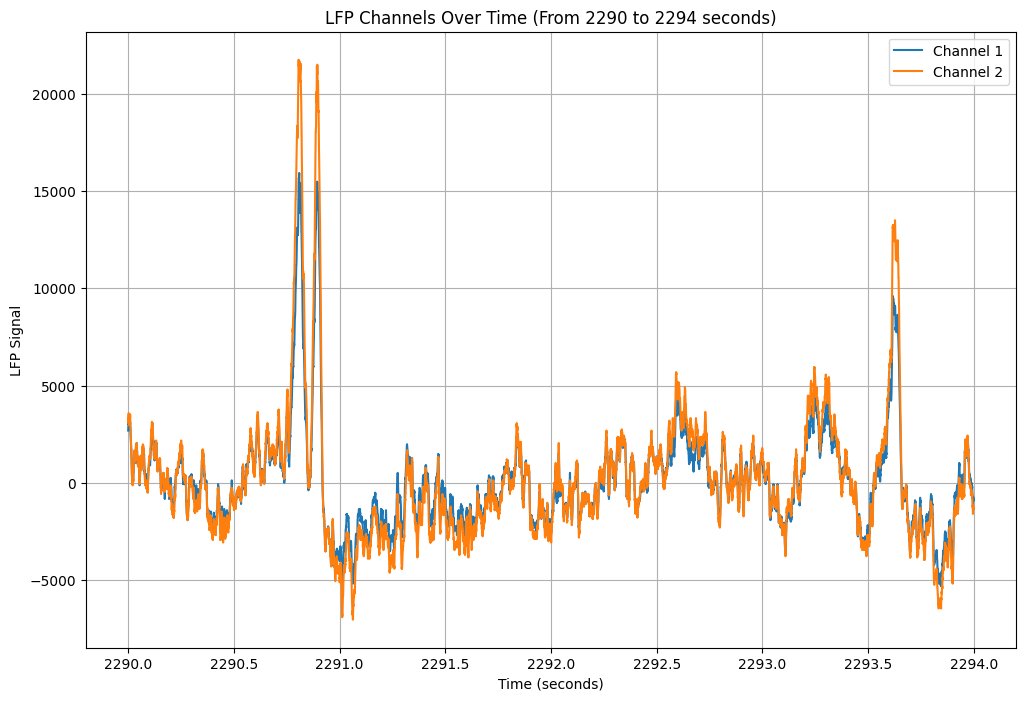

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define the channels to plot
channels_to_plot = [0, 1]  # Adjust these indices based on your specific channels

# Extract timestamps and LFP data for the selected channels
timestamps_sec = masked_BIGRAW[:, 0] / 1e6  # Convert timestamps from microseconds to seconds
lfp_data = masked_BIGRAW[:, 1:-3]

# Define the start and end time for the plot (in seconds)
start_time = 2290
end_time = 2294

# Find the indices corresponding to the start and end time
start_index = np.searchsorted(timestamps_sec, start_time)
end_index = np.searchsorted(timestamps_sec, end_time)

# Slice the data for the required duration
plot_timestamps = timestamps_sec[start_index:end_index]
plot_data = lfp_data[start_index:end_index, channels_to_plot]

# Plot the selected channels for the specified duration
plt.figure(figsize=(12, 8))
for i, channel_data in enumerate(plot_data.T):  # Transpose for channel-wise iteration
    plt.plot(plot_timestamps, channel_data, label=f'Channel {channels_to_plot[i] + 1}')

plt.xlabel('Time (seconds)')
plt.ylabel('LFP Signal')
plt.title(f'LFP Channels Over Time (From {start_time} to {end_time} seconds)')
plt.legend()
plt.grid(True)
plt.show()


Retrieved 34 flights for cluster 2.


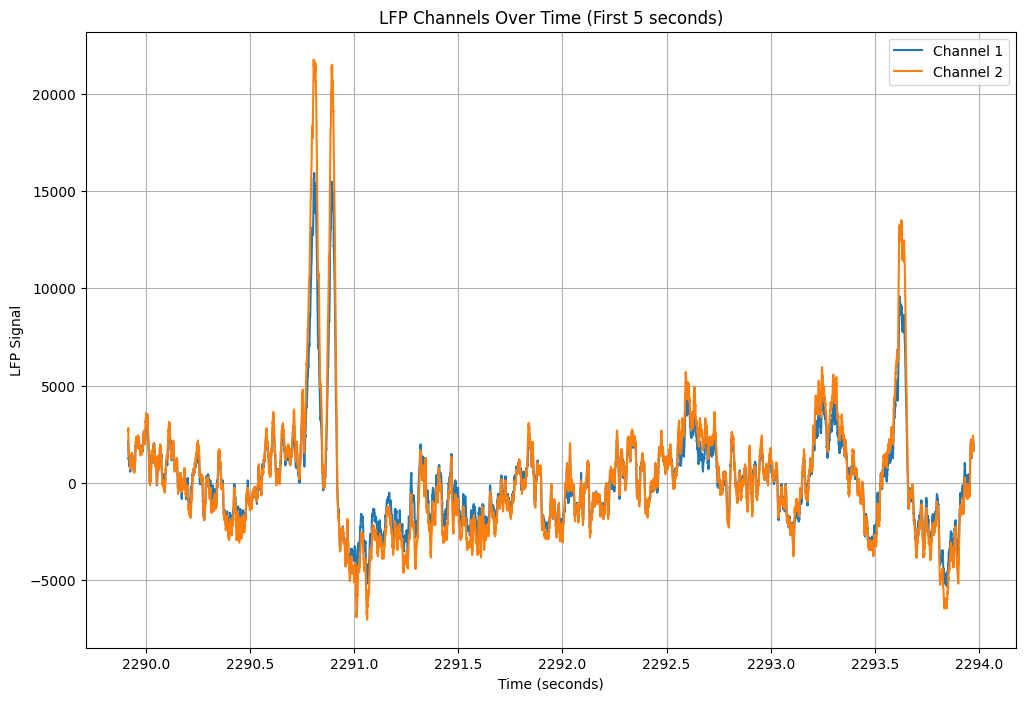

In [34]:
# Mask the raw data for the specified cluster and add flight info
filtered_BIGRAW = mask_by_cluster(session, masked_BIGRAW, cluster_id=2,buffer=0)
import matplotlib.pyplot as plt

# Define the channels to plot
channels_to_plot = [0, 1]  # Adjust these indices based on your specific channels

# Extract timestamps and LFP data for the selected channels
timestamps_sec = filtered_BIGRAW[:, 0] / 1e6  # Convert timestamps from microseconds to seconds
lfp_data = filtered_BIGRAW[:, 1:-4]

# Define the duration to plot (in seconds)
duration_to_plot = 5

# Find the indices corresponding to the duration to plot
end_index = np.searchsorted(timestamps_sec, timestamps_sec[0] + duration_to_plot)

# Slice the data once for the required duration
plot_timestamps = timestamps_sec[:end_index]
plot_data = lfp_data[:end_index, channels_to_plot]

# Plot the selected channels for the specified duration
plt.figure(figsize=(12, 8))
for i, channel_data in enumerate(plot_data.T):  # Transpose for channel-wise iteration
    plt.plot(plot_timestamps, channel_data, label=f'Channel {channels_to_plot[i] + 1}')

plt.xlabel('Time (seconds)')
plt.ylabel('LFP Signal')
plt.title(f'LFP Channels Over Time (First {duration_to_plot} seconds)')
plt.legend()
plt.grid(True)
plt.show()

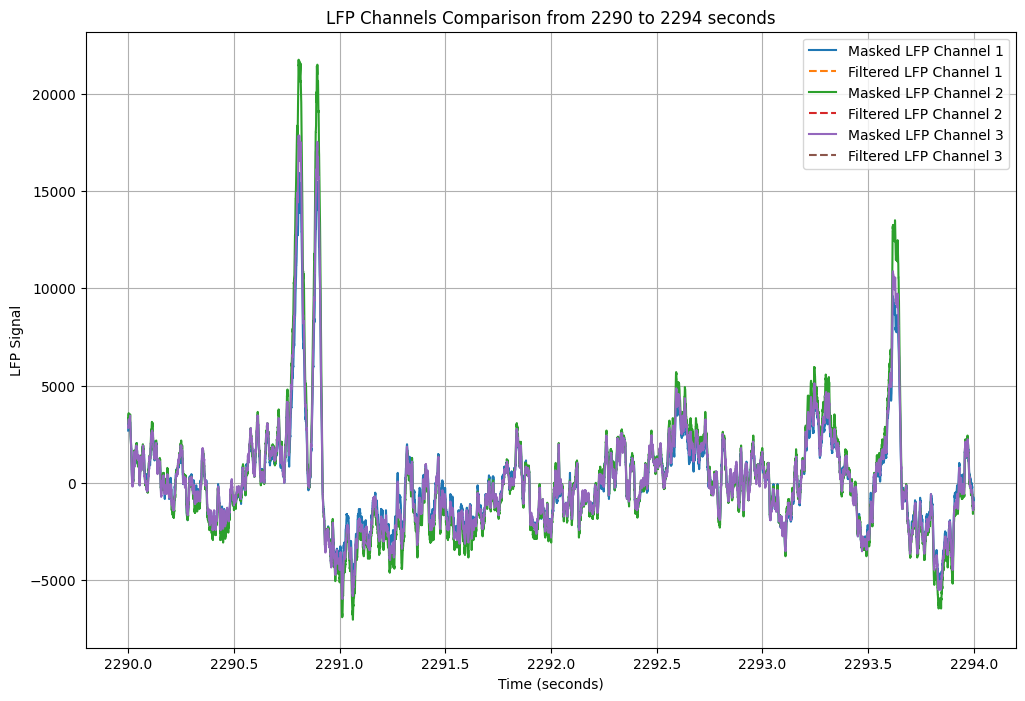

In [38]:
# Define the start and end time for the comparison (in seconds)
start_time = 2290
end_time = 2294

# Convert timestamps from microseconds to seconds
timestamps_sec = masked_BIGRAW[:, 0] / 1e6

# Find the indices corresponding to the start and end time
start_index = np.searchsorted(timestamps_sec, start_time)
end_index = np.searchsorted(timestamps_sec, end_time)

# Slice the data for the required duration
masked_slice = masked_BIGRAW[start_index:end_index]
filtered_slice = filtered_BIGRAW[start_index:end_index]

# Plot the comparison for the first few channels
plt.figure(figsize=(12, 8))
for channel in range(3):  # Adjust the range to plot more channels if needed
    plt.plot(masked_slice[:, 0] / 1e6, masked_slice[:, channel + 1], label=f'Masked LFP Channel {channel + 1}')
    plt.plot(filtered_slice[:, 0] / 1e6, filtered_slice[:, channel + 1], linestyle='--', label=f'Filtered LFP Channel {channel + 1}')

plt.xlabel('Time (seconds)')
plt.ylabel('LFP Signal')
plt.title(f'LFP Channels Comparison from {start_time} to {end_time} seconds')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Compute mean and standard deviation of LFP data before and after masking
masked_mean, masked_std = np.mean(masked_BIGRAW[:, 1:-3]), np.std(masked_BIGRAW[:, 1:-3])
filtered_mean, filtered_std = np.mean(filtered_BIGRAW[:, 1:-4]), np.std(filtered_BIGRAW[:, 1:-4])

print(f"Masked LFP Mean: {masked_mean}, Std: {masked_std}")
print(f"Filtered LFP Mean: {filtered_mean}, Std: {filtered_std}")


Masked LFP Mean: 0.0024453619945254725, Std: 1762.8956130156523
Filtered LFP Mean: 13.66137485039005, Std: 1547.0240518451258


### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [29]:
dsr = 100 #desired sampling rate

In [ ]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, pos_mask = sync_and_bin_data(lfp_mat, session,cleaned_pos,fs=dsr)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#pos_mask is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


In [ ]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [ ]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

In [ ]:
import matplotlib.pyplot as plt

# Plotting lfp_timestamps_edges
plt.figure(figsize=(10, 6))
plt.plot(lfp_timestamps_edges, label='LFP Timestamp Edges')
plt.xlabel('Index')
plt.ylabel('Timestamp (microseconds)')
plt.title('LFP Timestamp Edges')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
lfp_timestamps_edges_trim = lfp_timestamps_edges[:-1]
print(lfp_timestamps_edges_trim.shape)

##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

# Ben splits cluster 3

In [ ]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat,2500,dsr,use_cache=False) #uses scipy decimate to downsample LFP
#LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs = lfp_bat_combined[lfp_indices] # mask for non-negativity 

In [ ]:
lfp_bat_combined.shape


In [ ]:
lfp_time_diffs = np.diff(lfp_timestamps_edges)

# Convert the time differences to seconds
lfp_time_diffs_seconds = lfp_time_diffs / 1e6

# Calculate the mean of the time differences in seconds
mean_lfp_time_diff_seconds = np.mean(lfp_time_diffs_seconds)

# Calculate the sampling rate
lfp_sampling_rate = 1 / mean_lfp_time_diff_seconds

print(f"Estimated sampling rate of LFP timestamp edges: {lfp_sampling_rate} Hz")

In [ ]:
# Extract all flights in the third cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the minimum and maximum x-values
min_x_value = np.min(x_values)
max_x_value = np.max(x_values)

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the 3% buffer based on the range of x-values
x_range = max_x_value - min_x_value
buffer = 0.03 * x_range

# Define the range with the buffer around the median
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

print(f"Median x-value position: {median_x_value}")
print(f"Buffer range: ({lower_bound}, {upper_bound})")
# Extract all y-values from the flights
y_values = np.concatenate([flight.filtered_position[:, 1] for flight in flights_cluster])
y_values = y_values[~np.isnan(y_values)]

# Calculate the minimum and maximum y-values
min_y_value = np.min(y_values)
max_y_value = np.max(y_values)

# Calculate the median of the y-values
median_y_value = np.median(y_values)

# Calculate the 3% buffer based on the range of y-values
y_range = max_y_value - min_y_value
buffer_y = 0.03 * y_range

# Define the range with the buffer around the median
lower_bound_y = median_y_value - buffer_y
upper_bound_y = median_y_value + buffer_y

print(f"Median y-value position: {median_y_value}")
print(f"Buffer range: ({lower_bound_y}, {upper_bound_y})")

# color plots of median

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Extract all flights in the second cluster
flights_cluster = session.get_flights_by_cluster((3,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the buffer range
x_range = np.max(x_values) - np.min(x_values)
buffer = 0.03 * x_range
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

# Plot 3D flight paths, coloring based on the x-position relative to the median and buffer
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors for the regions
left_color = 'blue'
right_color = 'red'
buffer_color = 'black'

for flight in flights_cluster:
    # Extract the position data
    pos = flight.filtered_position
    x_coords, y_coords, z_coords = pos[:, 0], pos[:, 1], pos[:, 2]
    
    # Clean NaN values
    valid_mask = ~np.isnan(x_coords) & ~np.isnan(y_coords) & ~np.isnan(z_coords)
    x_coords, y_coords, z_coords = x_coords[valid_mask], y_coords[valid_mask], z_coords[valid_mask]
    
    # Determine colors for each segment based on x-coordinates
    for i in range(len(x_coords) - 1):
        # Assign color based on the position relative to the buffer
        if lower_bound <= x_coords[i] <= upper_bound:
            segment_color = buffer_color
        elif x_coords[i] < lower_bound:
            segment_color = left_color
        else:
            segment_color = right_color
        
        # Plot the line segment with the determined color
        ax.plot(x_coords[i:i+2], y_coords[i:i+2], z_coords[i:i+2], color=segment_color)

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('Flight Paths Colored by Position Relative to Median X and Buffer')

# Add a legend
legend_handles = [
    Line2D([0], [0], color=left_color, lw=4, label='Left of Buffer'),
    Line2D([0], [0], color=right_color, lw=4, label='Right of Buffer'),
    Line2D([0], [0], color=buffer_color, lw=4, label='Within Buffer'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Median X: {median_x_value:.2f}'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Buffer: ±{buffer:.2f}')
]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the view
ax.view_init(elev=50, azim=-120)

# Show the plot
plt.show()


In [40]:
def left_or_right(x, lower,upper):
    # Classify the input x values
    return np.where(
        x < lower, "left",  # Values less than the lower buffer are "left"
        np.where(x > upper, "right", "within buffer")  # Values greater than the upper buffer are "right"
    )

##### getting the binned position to match corresponding flights:
flight_count =0
flight_data = []
cluster=2

for flight in session.get_flights_by_cluster([cluster]): #marking cluster 3 flights
    flight_count +=1
    flight_bool, _ = get_flight_boolean_array(session,cluster,flight_count)

    # Apply pos_mask (formerly valid_indices) to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]
     # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
    
    flight_lfp = LFPs[timebin_labels > 0] # mark LFP points which mask to specific flight in cluste

     # Get binned position data for this flight
    flight_pos = binned_pos[timebin_labels > 0]
    
####### Current analysis task: marking whether current x is less than or greater than x=0
    flight_data.append(np.column_stack((
        np.full(len(flight_pos), flight_count),
        left_or_right(flight_pos[:,1], lower_bound_y, upper_bound_y),
        flight_lfp
    )))
    


In [41]:
flight_data = np.vstack(flight_data)

In [ ]:
flight_data

# Spectrogram of each flight w/in cluster 2

In [6]:
lfp_timestamps_sec = lfp_timestamps_edges_trim / 1e6

NameError: name 'lfp_timestamps_edges_trim' is not defined

Retrieved 34 flights for cluster 2.
Processing Flight 1.0: 10146 samples


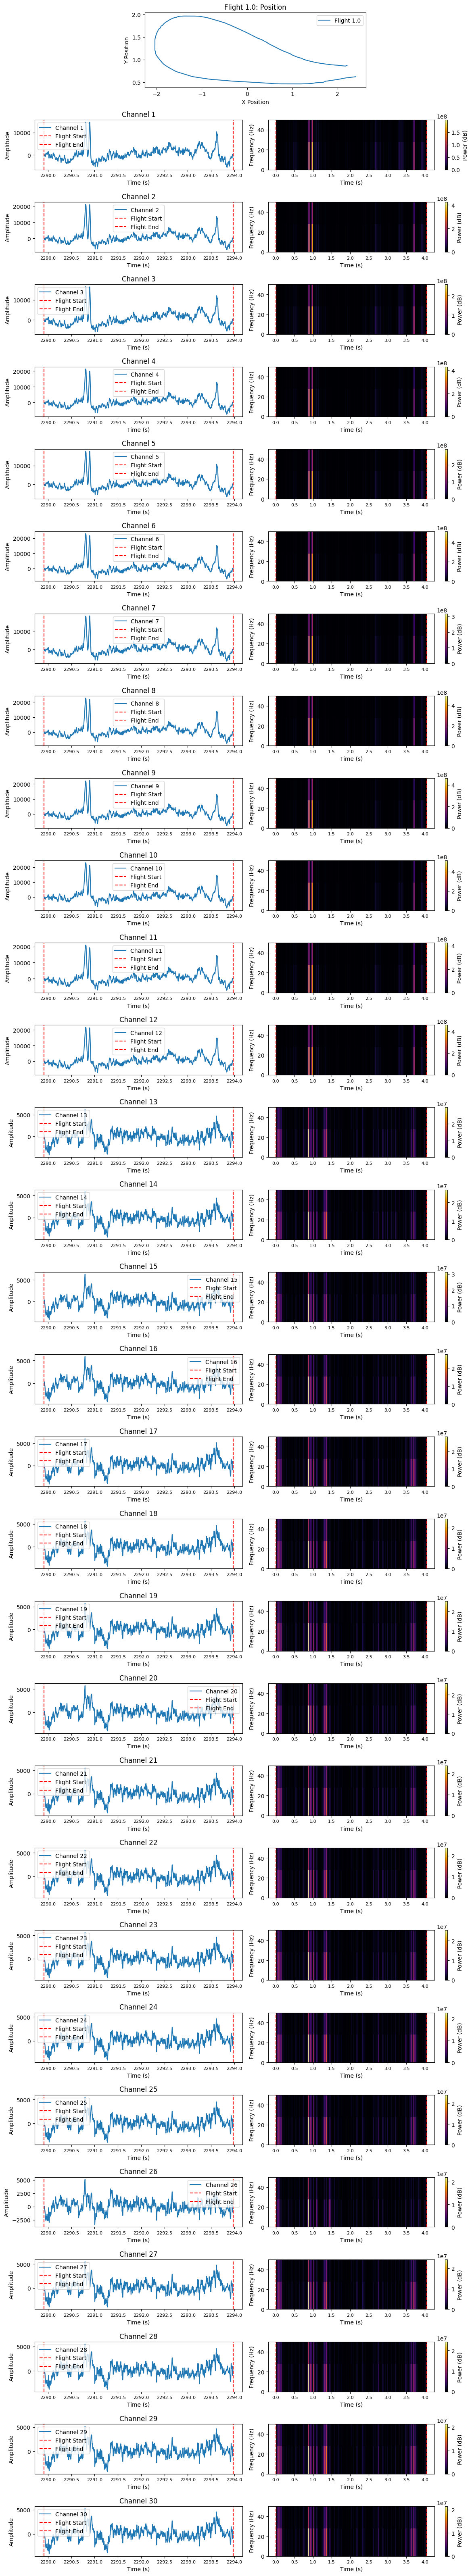

Processing Flight 2.0: 9917 samples


KeyboardInterrupt: 

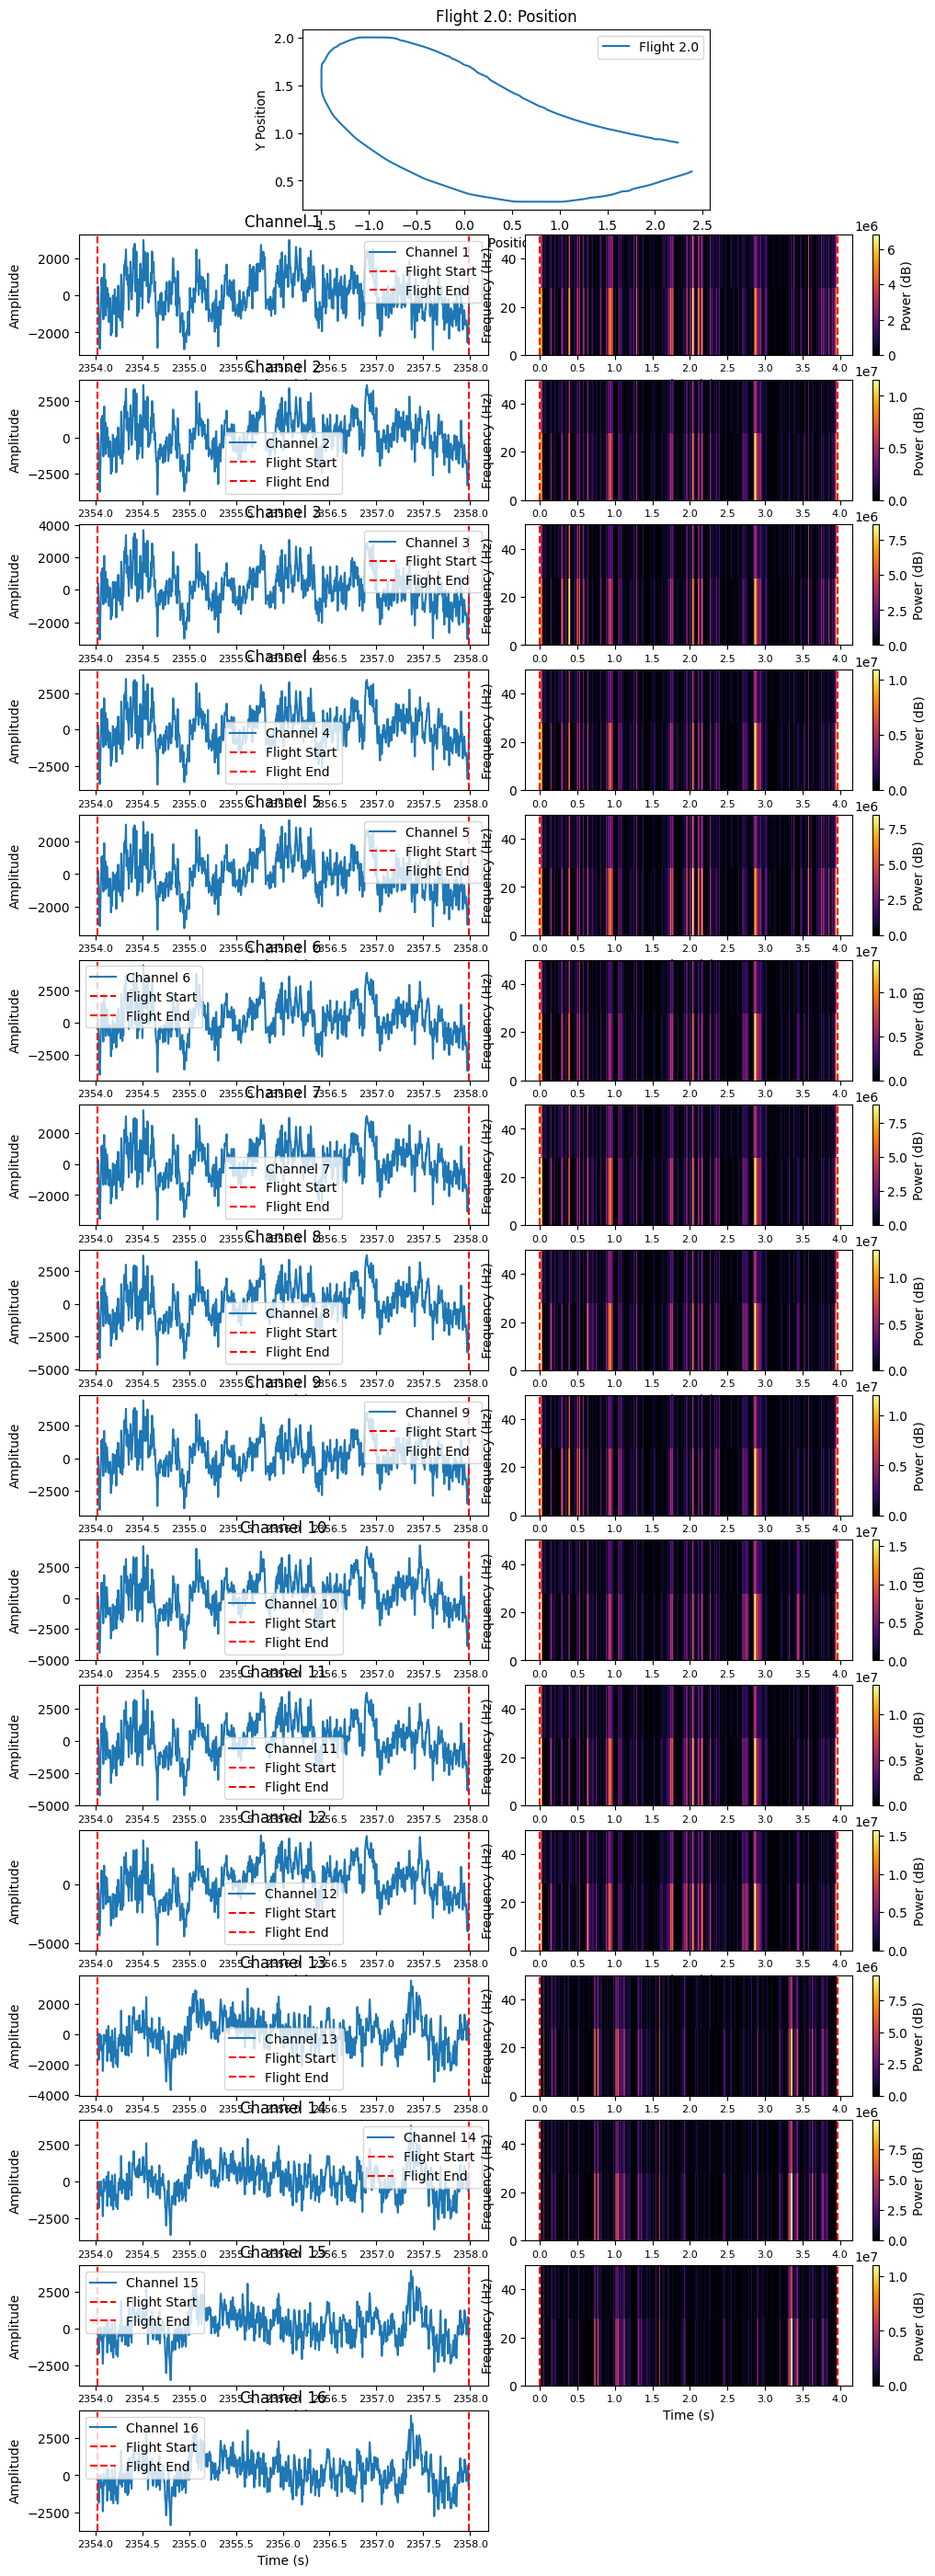

In [50]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.signal import spectrogram, butter, filtfilt
import numpy as np
from helpers import mask_by_cluster

# Parameters
cluster = 2
sampling_rate = 2500  # LFP sampling rate (Hz)
low_pass_20hz = 100  # Low-pass filter at 20 Hz
nperseg = 45  # Moderate segment length for better time resolution
noverlap = nperseg // 2  # 50% overlap
nfft = nperseg  # Zero-padding for frequency interpolation
window_type = 'hann'  # Hann window to reduce spectral leakage
detrend_type = False  # Detrend each segment
buffer = 0 # Time buffer in microseconds

# Butterworth band-pass filter design
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, method="gust")

# Mask the raw data for the specified cluster and add flight info
filtered_BIGRAW = mask_by_cluster(session, masked_BIGRAW, cluster_id=cluster, buffer=buffer)

# Extract data
timestamps = filtered_BIGRAW[:, 0]  # First column is timestamps
lfp_data = filtered_BIGRAW[:, 1:-4]  # LFP data (assuming 3 columns for positions)
positions = filtered_BIGRAW[:, -4:-1]  # Positional data (x, y, z)
flight_numbers = filtered_BIGRAW[:, -1]  # Flight numbers (last column)

# Iterate over unique flights in the cluster
unique_flights = np.unique(flight_numbers)
# Updated Plotting Code with Buffer Inclusion
for flight_idx in unique_flights:
    if flight_idx == 0:  # Skip rows with no flight information
        continue

    # Mask data for the current flight
    flight_mask = flight_numbers == flight_idx
    flight_timestamps = timestamps[flight_mask]
    flight_lfp = lfp_data[flight_mask]
    flight_positions = positions[flight_mask]

    # Determine flight start and end times with buffer
    flight_start = flight_timestamps[0] / 1e6 - buffer / 1e6  # Convert to seconds with buffer
    flight_end = flight_timestamps[-1] / 1e6 + buffer / 1e6  # Convert to seconds with buffer

    print(f"Processing Flight {flight_idx}: {len(flight_timestamps)} samples")

    # Create a grid layout for this flight
    num_channels = flight_lfp.shape[1]
    fig = plt.figure(figsize=(12, 4 + num_channels * 2))
    grid = GridSpec(num_channels + 1, 4, figure=fig, height_ratios=[1.5] + [1] * num_channels)

    # Plot flight position on top
    ax_pos = fig.add_subplot(grid[0, :])
    ax_pos.plot(flight_positions[:, 0], flight_positions[:, 1], label=f"Flight {flight_idx}")
    ax_pos.set_title(f"Flight {flight_idx}: Position")
    ax_pos.set_xlabel("X Position")
    ax_pos.set_ylabel("Y Position")
    ax_pos.legend()
    ax_pos.set_aspect('equal')  # Make the position plot square

    # Iterate over channels
    for channel in range(num_channels):
        # Select the specific channel
        channel_data = flight_lfp[:, channel]

        # Apply low-pass filter
        filtered_channel = bandpass_filter(channel_data, 0.1, low_pass_20hz, sampling_rate)

        # Raw signal plot
        ax_signal = fig.add_subplot(grid[channel + 1, 0:2])
        ax_signal.plot(flight_timestamps / 1e6, filtered_channel, label=f"Channel {channel + 1}")
        ax_signal.axvline(flight_start, color="red", linestyle="--", label="Flight Start")
        ax_signal.axvline(flight_end, color="red", linestyle="--", label="Flight End")
        ax_signal.set_title(f"Channel {channel + 1}")
        ax_signal.set_xlabel("Time (s)")
        ax_signal.set_ylabel("Amplitude")
        ax_signal.legend()
        ax_signal.tick_params(axis="x", labelsize=8)

        # Spectrogram plot
        f, t, Sxx = spectrogram(
            filtered_channel,
            fs=sampling_rate,
            window=window_type,
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft,
            detrend=detrend_type,
            scaling='spectrum',
            mode='psd'
        )

        ax_spec = fig.add_subplot(grid[channel + 1, 2:])
        spec = ax_spec.pcolormesh(t, f, Sxx, shading="auto", cmap="inferno")
        ax_spec.axvline(flight_start - flight_timestamps[0] / 1e6, color="red", linestyle="--", label="Flight Start")
        ax_spec.axvline(flight_end - flight_timestamps[0] / 1e6, color="red", linestyle="--", label="Flight End")
        plt.colorbar(spec, ax=ax_spec, label="Power (dB)")
        ax_spec.set_xlabel("Time (s)")
        ax_spec.set_ylabel("Frequency (Hz)")
        ax_spec.set_ylim(0, 50)  # Focus on frequencies below 50 Hz
        ax_spec.tick_params(axis="x", labelsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()


## training TIMBRE

In [45]:
label_mapping = {"left": 0, "right": 1}
classifications = flight_data[:,1]
# Assuming flight_data[:, 2] is a 2D array of strings
# Convert all elements to complex numbers while preserving the original shape
lfp_data = np.array([np.array([complex(val) for val in row]) for row in flight_data[:, 2:]])

# Map the labels to integers
Y = np.array([label_mapping[label] for label in classifications if label != "within buffer"])  # Exclude buffer range

# Extract the LFP data corresponding to non-"0" labels
X = lfp_data[classifications != "within buffer"]  # Use rows where the labels aren't "0"

In [ ]:
X

In [ ]:
# distribution of categorical labels
unique, counts = np.unique(Y, return_counts=True)
total = len(Y)
distribution = {label: (count / total) * 100 for label, count in zip(unique, counts)}
print(distribution)

In [ ]:
Y.shape, X.shape

In [ ]:
from sklearn.model_selection import KFold
from TIMBRE import TIMBRE

k = 3 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
hidden_nodes=3
learn_rate=0.1
is_categorical=True

# Assuming X and Y are your data and labels
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    # Use train_index and test_index to index into X and Y
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Call TIMBRE or other model with the current fold's train-test split
    model, fitted_model, test_acc = TIMBRE(
        X=X,
        Y=Y,
        inds_test=test_index,
        inds_train=train_index,
        hidden_nodes=hidden_nodes,
        learn_rate=learn_rate,
        is_categorical=is_categorical,
        verbosity=0
    )

    print(f"Fold {fold + 1} Test Accuracy: {test_acc}")

In [ ]:
from matplotlib import pyplot as plt

# Plot accuracy and loss from fittedModel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot training vs. validation accuracy
axs[0].plot(fitted_model.history['accuracy'], label='Train')
axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Training epoch')
axs[0].legend()

# Plot training vs. validation loss
axs[1].plot(fitted_model.history['loss'], label='Train')
axs[1].plot(fitted_model.history['val_loss'], label='Test')
axs[1].set_title('Loss')
axs[1].set_xlabel('Training epoch')
axs[1].legend()

plt.tight_layout()
plt.show()


In [51]:
from sklearn.model_selection import train_test_split

# Split indices into training and testing sets
inds_train, inds_test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

In [ ]:
from TIMBRE import TIMBRE
from matplotlib import pyplot as plt
import numpy as np

# Parameters for TIMBRE
hidden_node_sizes = [3, 10, 30]  # Hidden node sizes to test
learn_rate = 0.001
is_categorical = True
iterations = 3  # Number of iterations per hidden node size

# Store results
results = {size: [] for size in hidden_node_sizes}

# Loop over hidden node sizes and iterations
for hidden_nodes in hidden_node_sizes:
    for iteration in range(iterations):
        print(f"Testing hidden_nodes={hidden_nodes}, iteration={iteration + 1}")

        # Call TIMBRE
        model, fitted_model, test_acc = TIMBRE(
            X=X,
            Y=Y,
            inds_test=inds_test,
            inds_train=inds_train,
            hidden_nodes=hidden_nodes,
            learn_rate=learn_rate,
            is_categorical=is_categorical,
            verbosity=0  # Suppress detailed output for cleaner logs
        )

        # Store test accuracy
        results[hidden_nodes].append(test_acc)
        print(f"Test Accuracy: {test_acc}")

        # Plot accuracy and loss from fittedModel
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot training vs. validation accuracy
        axs[0].plot(fitted_model.history['accuracy'], label='Train')
        axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Training epoch')
        axs[0].legend()

        # Plot training vs. validation loss
        axs[1].plot(fitted_model.history['loss'], label='Train')
        axs[1].plot(fitted_model.history['val_loss'], label='Test')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Training epoch')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

# Calculate average accuracy for each hidden node size
average_accuracies = {size: np.mean(accs) for size, accs in results.items()}

# Print results
print("\nResults:")
for size, accs in results.items():
    print(f"Hidden Nodes: {size}, Accuracies: {accs}, Average Accuracy: {average_accuracies[size]}")

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))

hidden_sizes = list(average_accuracies.keys())
average_accs = list(average_accuracies.values())

ax.bar(hidden_sizes, average_accs, color='skyblue')
ax.set_title("Average Test Accuracy vs Hidden Node Size")
ax.set_xlabel("Hidden Node Size")
ax.set_ylabel("Average Test Accuracy")
plt.xticks(hidden_sizes)
plt.tight_layout()
plt.show()
